          Date  AUD_NZD_ExRate
0   2024/04/01        1.090956
1   2024/04/02        1.090165
2   2024/04/03        1.091675
3   2024/04/04        1.091893
4   2024/04/05        1.093491
5   2024/04/06        1.094021
6   2024/04/07        1.093987
7   2024/04/08        1.093680
8   2024/04/09        1.094648
9   2024/04/10        1.093387
10  2024/04/11        1.088948
11  2024/04/12        1.089553
12  2024/04/13        1.088733
13  2024/04/14        1.088902
14  2024/04/15        1.089366
15  2024/04/16        1.091138
16  2024/04/17        1.089043
17  2024/04/18        1.087824
18  2024/04/19        1.087785
19  2024/04/20        1.089792
20  2024/04/21        1.089470
21  2024/04/22        1.089110
22  2024/04/23        1.089638
23  2024/04/24        1.092450
24  2024/04/25        1.094952
25  2024/04/26        1.095309
26  2024/04/27        1.099260
27  2024/04/28        1.099193
28  2024/04/29        1.099441
29  2024/04/30        1.098571
Report:
-------
Date Range: 2024-04-01 

<Figure size 720x432 with 0 Axes>

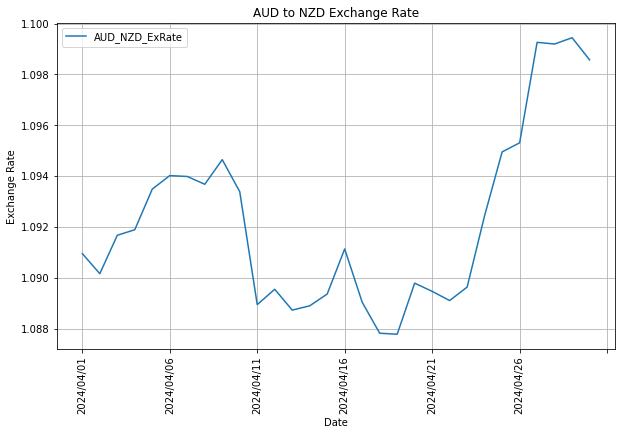

In [3]:
import requests
import json
from datetime import date, timedelta, datetime
import time
import pandas as pd
from diskcache import Cache
import os
import configparser
import matplotlib.pyplot as plt


def get_date_range(num_days):
    """Get the desired date range based on the number of days."""
    end_date = date.today() - timedelta(days=1)
    start_date = end_date - timedelta(days=num_days - 1)
    return start_date, end_date


def build_request_url(base_url, api_key, base_currency, date_obj):
    """Build the request URL with parameters."""
    date_str = date_obj.strftime('%Y/%m/%d')
    return f"{base_url}/{api_key}/history/{base_currency}/{date_str}"


def fetch_exchange_rate(api_url, current_date_str, cache):
    """Fetch the exchange rate for a specific date."""
    if current_date_str in cache:
        return cache[current_date_str]

    try:
        response = requests.get(api_url)
        response.raise_for_status()
        data = response.json()
        if 'result' in data and data['result'] == 'success':
            nzd_value = data["conversion_rates"]["NZD"]
            cache[current_date_str] = nzd_value
            return nzd_value
        else:
            print(f'API call failed for {current_date_str}')
    except requests.exceptions.RequestException as e:
        print(f'An error occurred: {str(e)}')

    return None


def fetch_exchange_rate_data(start_date, end_date, base_currency, api_key, base_url):
    """Fetch the exchange rate data for the specified date range."""
    df = pd.DataFrame(columns=['Date', 'AUD_NZD_ExRate'])
    cache_file = 'cache_exchange_rate_file'
    cache = Cache(cache_file)

    current_date = start_date
    while current_date <= end_date:
        current_date_str = current_date.strftime('%Y/%m/%d')
        api_url = build_request_url(base_url, api_key, base_currency, current_date)

        nzd_value = fetch_exchange_rate(api_url, current_date_str, cache)
        if nzd_value is not None:
            df.loc[len(df)] = {'Date': current_date_str, 'AUD_NZD_ExRate': nzd_value}

        current_date += timedelta(days=1)

    cache.close()
    return df


def calculate_exchange_rate_statistics(df):
    """Calculate the best, worst, and average exchange rates."""
    best_rate = df['AUD_NZD_ExRate'].max()
    worst_rate = df['AUD_NZD_ExRate'].min()
    average_rate = df['AUD_NZD_ExRate'].mean()
    return best_rate, worst_rate, average_rate


def print_report(df, start_date_str, end_date_str, best_rate, worst_rate, average_rate):
  """Print the exchange rate data and the report."""
  print(df)
  print('Report:')
  print('-------')
  print(f'Date Range: {start_date_str} - {end_date_str}')
  print(f'Number of days: {len(df)}')

  # Find dates for best and worst rates (assuming unique values)
  if best_rate is not None:
    best_rate_date = df[df['AUD_NZD_ExRate'] == best_rate]['Date'].iloc[0]
    print(f'Best exchange rate: \033[1m{best_rate:.5f} (on {best_rate_date})\033[0m')
  else:
    print(f'Best exchange rate: \033[1mNo data\033[0m')

  if worst_rate is not None:
    worst_rate_date = df[df['AUD_NZD_ExRate'] == worst_rate]['Date'].iloc[0]
    print(f'Worst exchange rate: \033[1m{worst_rate:.5f} (on {worst_rate_date})\033[0m')
  else:
    print(f'Worst exchange rate: \033[1mNo data\033[0m')

  if average_rate is not None:
    print(f'Average exchange rate: \033[1m{average_rate:.5f}\033[0m')
  else:
    print(f'Average exchange rate: \033[1mNo data\033[0m')
import matplotlib.pyplot as plt

def plot_exchange_rate_data(df):
    """Plot the exchange rate data."""
    plt.figure(figsize=(10, 6))

    # Use df.plot for basic plotting (adjust kind='line' if needed)
    df.plot(kind='line', x='Date', y='AUD_NZD_ExRate', figsize=(10, 6))
    plt.title('AUD to NZD Exchange Rate')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.xticks(rotation='vertical')  # Rotate x-axis labels vertically
    plt.grid(True)
    plt.show()
    
def get_api_key():
  """Retrieves the API key from a configuration file."""
  config = configparser.ConfigParser()
  try:
    config.read('config.ini')
    return config.get('API', 'API_KEY')
  except (FileNotFoundError, configparser.NoSectionError):
    print("API key not found in the configuration file.")
    return None

def main():
    """Main function to fetch exchange rate data, calculate statistics, and plot the data."""
    API_KEY = get_api_key()
    if API_KEY is None:
        print("API key not found in the configuration file.")
        return

    BASE_URL = 'https://v6.exchangerate-api.com/v6'
    BASE_CURRENCY = 'AUD'
    NUM_DAYS = 30

    start_date, end_date = get_date_range(NUM_DAYS)
    df = fetch_exchange_rate_data(start_date, end_date, BASE_CURRENCY, API_KEY, BASE_URL)
    best_rate, worst_rate, average_rate = calculate_exchange_rate_statistics(df)
    print_report(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), best_rate, worst_rate, average_rate)
    plot_exchange_rate_data(df)
    
    # Save DataFrame to CSV
    df.to_csv('exchange_rate_data.csv', index=False)

    # Append reported variables to the existing CSV file
    report_data = {
        'Start Date': [start_date.strftime('%Y-%m-%d')],
        'End Date': [end_date.strftime('%Y-%m-%d')],
        'Number of days': [len(df)],
        'Best Exchange Rate': [best_rate],
        'Worst Exchange Rate': [worst_rate],
        'Average Exchange Rate': [average_rate]
    }
    report_df = pd.DataFrame(report_data)
    report_df.to_csv('exchange_rate_data.csv', mode='a', header=True, index=False)


if __name__ == '__main__':
    main()
